In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [7]:
# read data
park = pd.read_csv("data/parks.csv", sep=";")
park

,ParkID,Name,Official,Advisories,SpecialFeatures,Facilities,Washrooms,StreetNumber,StreetName,EWStreet,NSStreet,NeighbourhoodName,NeighbourhoodURL,Hectare,GoogleMapDest
0,2,Carnarvon Park,1,N,N,Y,Y,2995,W 19th Avenue,W 19th Avenue,Mackenzie Street,Arbutus-Ridge,https://vancouver.ca/news-calendar/arbutus-rid...,3.79,"49.256555, -123.171406"
1,13,Coal Harbour Park,1,N,N,Y,N,480,Broughton Street,W Hastings Street,Broughton Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.95,"49.289981, -123.125015"
2,16,David Lam Park,1,N,Y,Y,Y,1300,Pacific Boulevard,Drake Street,Pacific Boulevard,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,4.34,"49.272569, -123.124145"
3,25,May & Lorne Brown Park,1,N,N,N,N,801,Beach Avenue,Beach Avenue,Hornby Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.25,"49.275188, -123.132046"
4,26,Pioneer Place (Pigeon Park),1,N,N,N,N,399,Carrall Street,W Hastings Street,Carrall Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.03,"49.281699, -123.104588"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,235,Granville Island Water Park,0,N,N,Y,N,1348,Cartwright Street,NaN,NaN,Fairview,https://vancouver.ca/news-calendar/fairview.aspx,0.00,"49.26955, -123.135064"
214,237,Yaletown Park,1,N,N,N,N,901,Mainland Street,Mainland Street,Nelson Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.17,"49.277042, -123.118921"
215,238,Carolina Park,1,N,N,N,N,2100,Carolina Street,E 5th Avenue,Carolina Street,Mount Pleasant,https://vancouver.ca/news-calendar/mount-pleas...,0.08,"49.266401, -123.090778"
216,241,Habitat Island,0,N,N,N,N,1616,Columbia Street,NaN,NaN,Mount Pleasant,https://vancouver.ca/news-calendar/mount-pleas...,0.60,"49.27221, -123.110791"


In [8]:
# Summary of dataframe
park.describe()

,ParkID,Official,StreetNumber,Hectare
count,218.000000,218.000000,218.000000,218.000000
mean,119.908257,0.917431,2841.137615,6.200459
std,70.243689,0.275863,2128.224454,28.690242
min,1.000000,0.000000,50.000000,0.000000
25%,61.250000,1.000000,1177.250000,0.455000
50%,117.500000,1.000000,2390.000000,1.400000
75%,178.500000,1.000000,3930.750000,3.812500
max,249.000000,1.000000,9250.000000,400.000000


In [9]:
# listing features in dataframe
numeric_features = ['Hectare']
categorical_features = ['NeighbourhoodName']
binary_features = ['Official', 'Advisories', 'SpecialFeatures', 'Facilities']
drop_features = ['NeighbourhoodURL', 'ParkID', 'Name', 'GoogleMapDest', 'StreetNumber', 'StreetName', 'EWStreet', 'NSStreet']
target = "Washrooms"

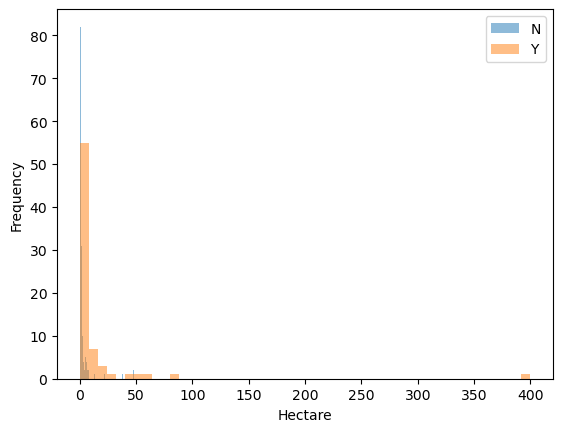

In [10]:
# Visualize numeric features
for col in numeric_features:
    park.groupby(target)[col].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(col);
    plt.show()

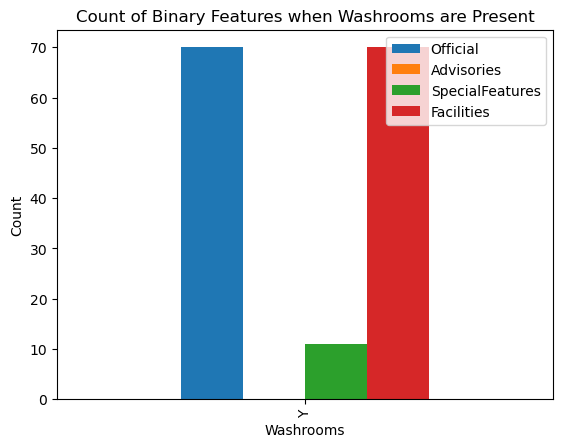

In [11]:
# Visualize binary features when there is washroom
binary_df = park[binary_features + [target]].copy()
binary_df['Official'] = binary_df['Official'].astype(str).replace({"1": "Y", "0": "N"})
washroom_df = binary_df[binary_df[target] == "Y"]
washroom_df_count = washroom_df.groupby(target)[binary_features].apply(lambda group: (group == "Y").sum())
washroom_df_count
washroom_df_count.plot.bar()
plt.title("Count of Binary Features when Washrooms are Present")
plt.ylabel("Count")
plt.show()

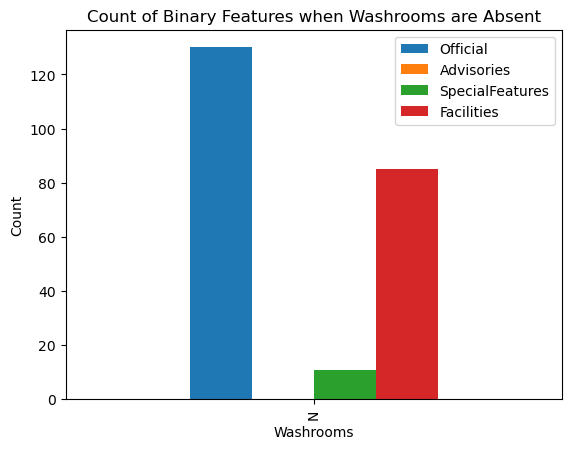

In [12]:
# Visualize binary features when there is no washroom
no_washroom_df = binary_df[binary_df[target] == "N"]
no_washroom_df_count = no_washroom_df.groupby(target)[binary_features].apply(lambda group: (group == "Y").sum())
no_washroom_df_count
no_washroom_df_count.plot.bar()
plt.title("Count of Binary Features when Washrooms are Absent")
plt.ylabel("Count")
plt.show()

In [13]:
# preprocessor for column transformation
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"), OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)
preprocessor = make_column_transformer(
(StandardScaler(), numeric_features),
(OneHotEncoder(), binary_features),
(categorical_transformer, categorical_features),
("drop", drop_features)
)

In [14]:
# train and test data set up
train_df = train_test_split(park, test_size=0.6, random_state=123)[0]
test_df = train_test_split(park, test_size=0.6, random_state=123)[1]
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]
y_test

204    Y
203    N
31     N
186    Y
169    N
      ..
199    N
179    N
200    Y
87     N
9      Y
Name: Washrooms, Length: 131, dtype: object

In [15]:
# Function for cv score, adapted from 571 lab 2
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    Parameters
    ----------
    model :
    scikit-learn model
    X_train : numpy array or pandas DataFrame
    X in the training data
    y_train :
    y in the training data
    Returns
    ----------
    pandas Series with mean scores from cross_validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [16]:
# Setup model and pipline
model = DummyClassifier(random_state=123)
pipe = make_pipeline(preprocessor, model)

In [17]:
dummy_df = pd.DataFrame({
    "dummy" : mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True)
})
dummy_df.transpose()

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.003 (+/- 0.000),0.748 (+/- 0.023),0.747 (+/- 0.006)


In [18]:
# RBF SVC model implementation
svm_rbf_classifier = SVC(kernel='rbf', C=1.0, gamma='scale') 
pipe2 = make_pipeline(preprocessor, svm_rbf_classifier)
svm_rbf_df = pd.DataFrame({
    "svm_rbf" : mean_std_cross_val_scores(pipe2, X_train, y_train, cv=5, return_train_score=True)
})
svm_rbf_df.transpose()

,fit_time,score_time,test_score,train_score
svm_rbf,0.005 (+/- 0.001),0.003 (+/- 0.001),0.771 (+/- 0.051),0.807 (+/- 0.022)


In [19]:
# knn model implementation
knn_classifier = KNeighborsClassifier(n_neighbors=5)
pipe3 = make_pipeline(preprocessor, knn_classifier)
knn_df = pd.DataFrame({
    "knn" : mean_std_cross_val_scores(pipe3, X_train, y_train, cv=5, return_train_score=True)
})
knn_df.transpose()

,fit_time,score_time,test_score,train_score
knn,0.005 (+/- 0.002),0.009 (+/- 0.016),0.746 (+/- 0.058),0.833 (+/- 0.019)


In [20]:
result = pd.merge(dummy_df, svm_rbf_df, left_index=True, right_index=True)
result = pd.merge(result, knn_df, left_index=True, right_index=True)
result

,dummy,svm_rbf,knn
fit_time,0.005 (+/- 0.001),0.005 (+/- 0.001),0.005 (+/- 0.002)
score_time,0.003 (+/- 0.000),0.003 (+/- 0.001),0.009 (+/- 0.016)
test_score,0.748 (+/- 0.023),0.771 (+/- 0.051),0.746 (+/- 0.058)
train_score,0.747 (+/- 0.006),0.807 (+/- 0.022),0.833 (+/- 0.019)
